<a href="https://colab.research.google.com/github/nomadicsenseis/annoted-transformer/blob/main/The_Annoted_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Since their first appearance in the now famous DeepMind's paper "Attention is all you need" by Vaswani et al. (2017), transformers have changed the state of the art in many of the sequential tasks related with artificial intelegence. In particular, they have outstand in natural language processing, where RNN's (including gates) and CNN's could not. As the title of the paper suggest, they base their functioning on the attention mechanism, which will be explained further down this notebook.

From a linguistic point of view, the outstanding performance of a deep learning model in contructing coherent and gramatically correct language seems to question the symbolic approach championed by the famous Noam Chomsky. No disctintion is made in a tranformer about sintactics of semantics what so ever, and definetly no symbolic rule, other that the usual supervised machine learning procedure, is implemented. That being said, a transformer is not agnostic to the problem to which it is applied. Their very structure of learning, which it so very well recreates sintactic rules, is based, at the very least, on our notion of language being sequential. Even more, the vectors query, key and value used in the attention mechanism, have been thought of as tools to describe both the sintactical and semantical nature of the context of a word withing a sentence. From my understanding, it is astonishing how rules we though innate to our understanding (in this case lingüistic) can be infered from a particular learning structure. Who knows, maybe some of the logical inference rules used in modern mathematics are just stable stader of a particular learning structure within our brains. 

But, what is a transformer? How does it work? According tot he original paper a trnasformer its a deep neural network that answers to the following structure:

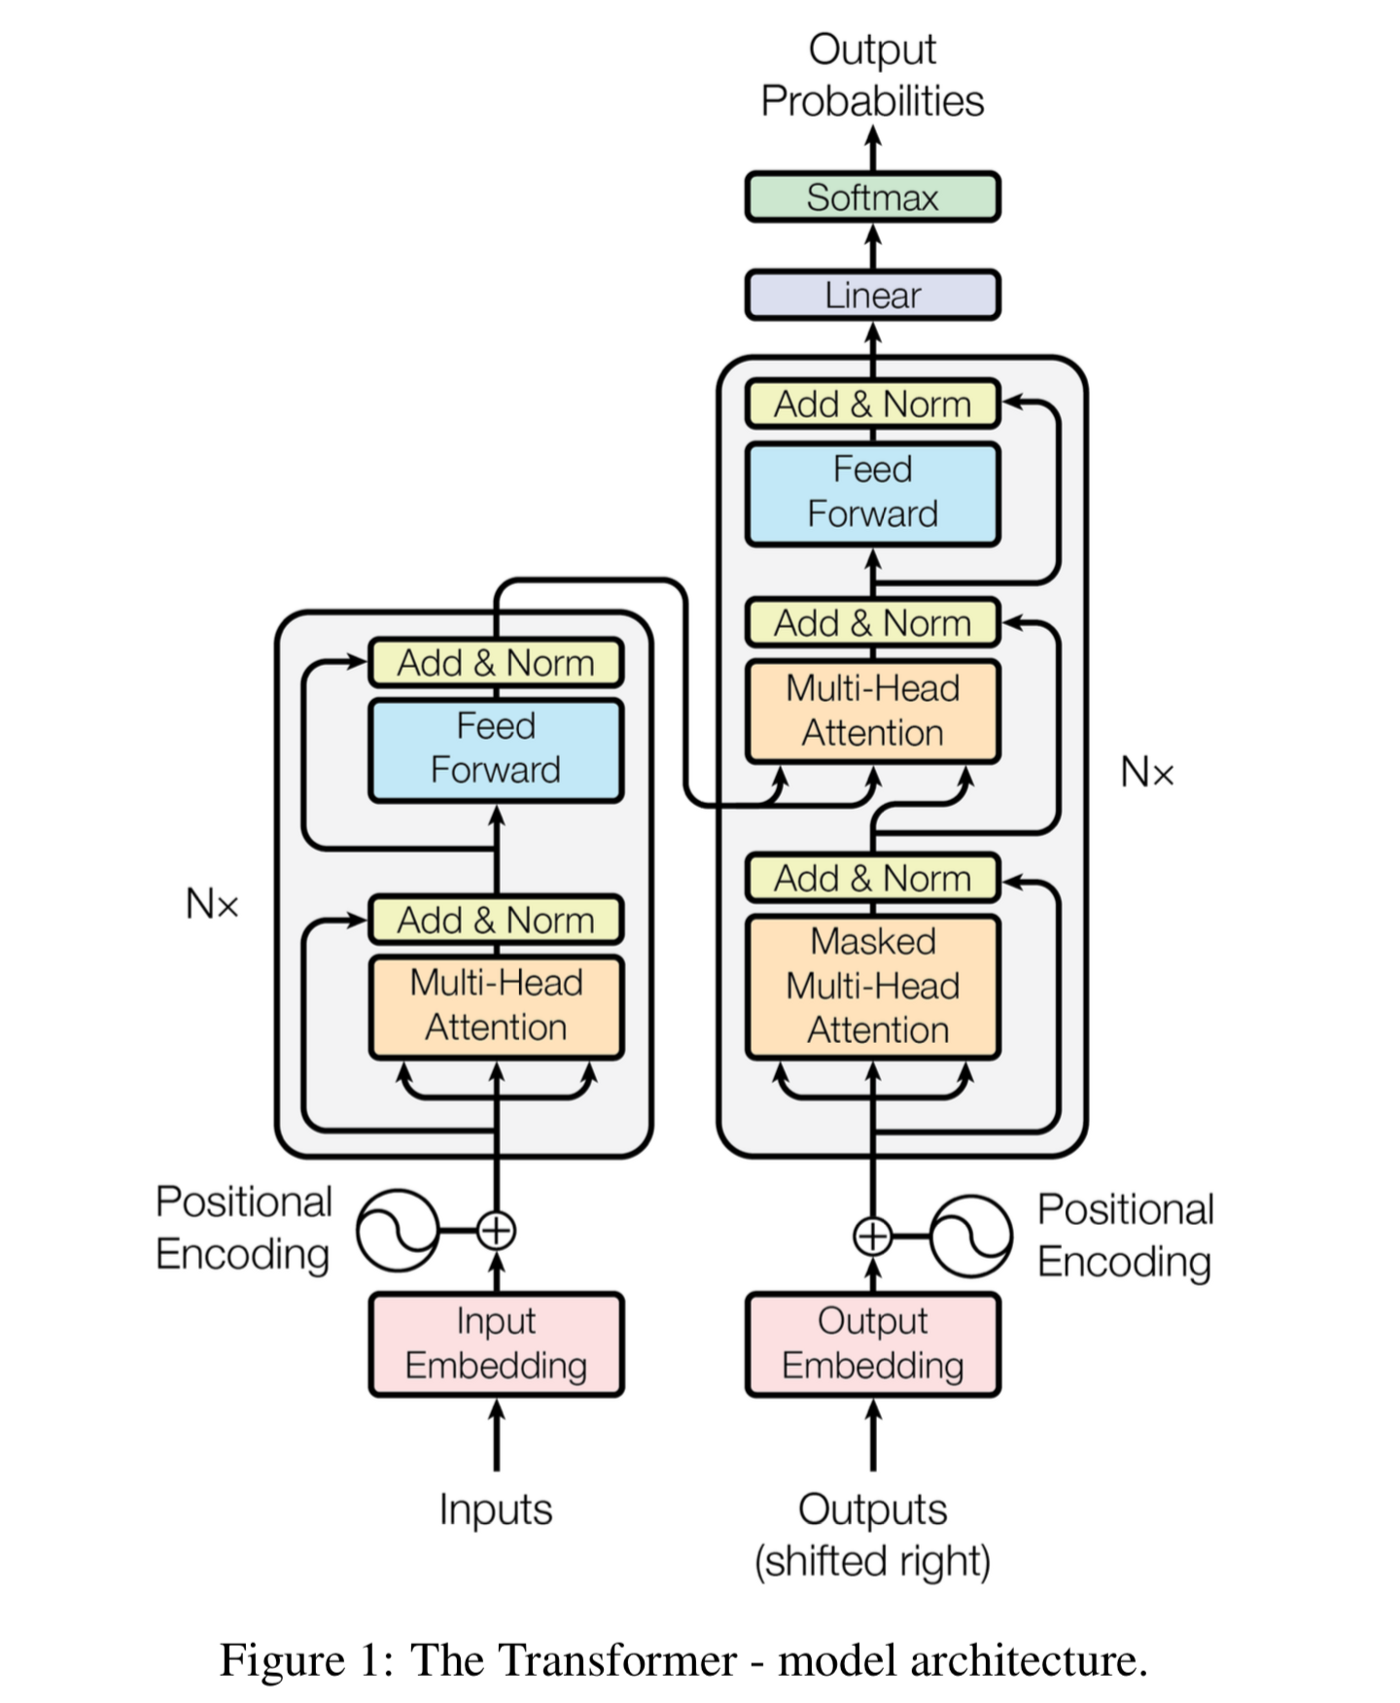

In [ ]:
from IPython.display import Image
Image(filename='/content/transformer.png', width=500, height=600)

Although this is the most popular way of presenting a Transformer, I find it way too ambiguous. Here is a more concrete version using pseudo-code, taken from my work "Attention is not all you need" and based on the paper "Formal Algorithms for transformers" by DeepMind. 

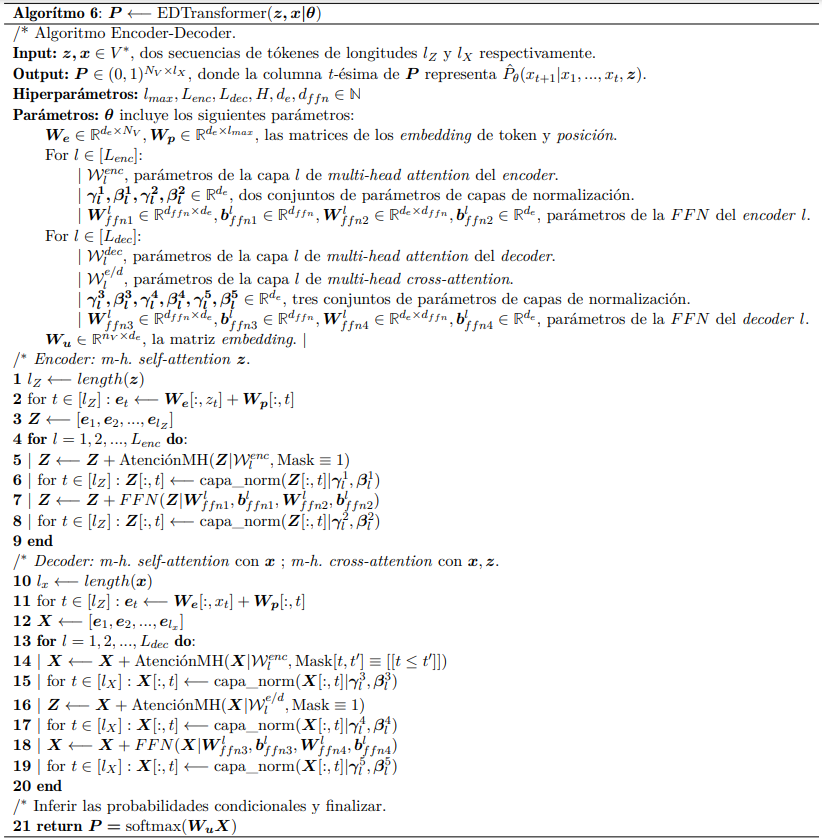

In [ ]:
from IPython.display import Image
Image(filename='/content/EDTransformer.png', width=500, height=550)

The overall structure of an ED transformer can be divided in two modules: and Encoder and a Decoder. Personally, I think this division is quite usefull for understanding "sequentially" how a transformer works, that is, how token representations are treated as they get into the network for computing their context representation. This sequential understanding is key for getting an intuition on why using Encoder-only or Decoder-only architectures, and also on why Transformers work as well as they do on the particular problems (sequential problems as NLP, or image processing) they are used in. 

Now, for understanding how to implement a transformer from an OOP perspective, I find that it is way more usefull to look at a tranformer as a set of simple neural network modules, each one placed one or more times withing the overall transformer architecture. From these simpler modules, I am going to build larger ones, so in a way I will be building the transformer from the inside out. There are many different strategies when doing this, here I will cover two of them: the one by Harvard NLP team (based on a PyTorch implementation) and the one by the Tensorflow team. It is important to notice that they are just two examples that help us get the idea, but there are many ways to structure the programming of the modules. Some of them will be overritten classes from either PyTorch modules or Keras layers. Some of them will be just functions instantiating those modules. Changing the nature of the modules is perfectly posible, as long as the "sequential" logig of a transformer remains unchanged. There migh be some considerations about its efficiency (expecially on trainning) though, so just to be sure everything is fine I only cover these two examples.

#The Annoted Transformer by Harvard NLP

As I said, there are different strategies for implementing a ED transformer. I will go through one of the most famous ones "The Annoted Transformer" by Harvard NLP team in the following section.

Lets take a look at the class diagram:

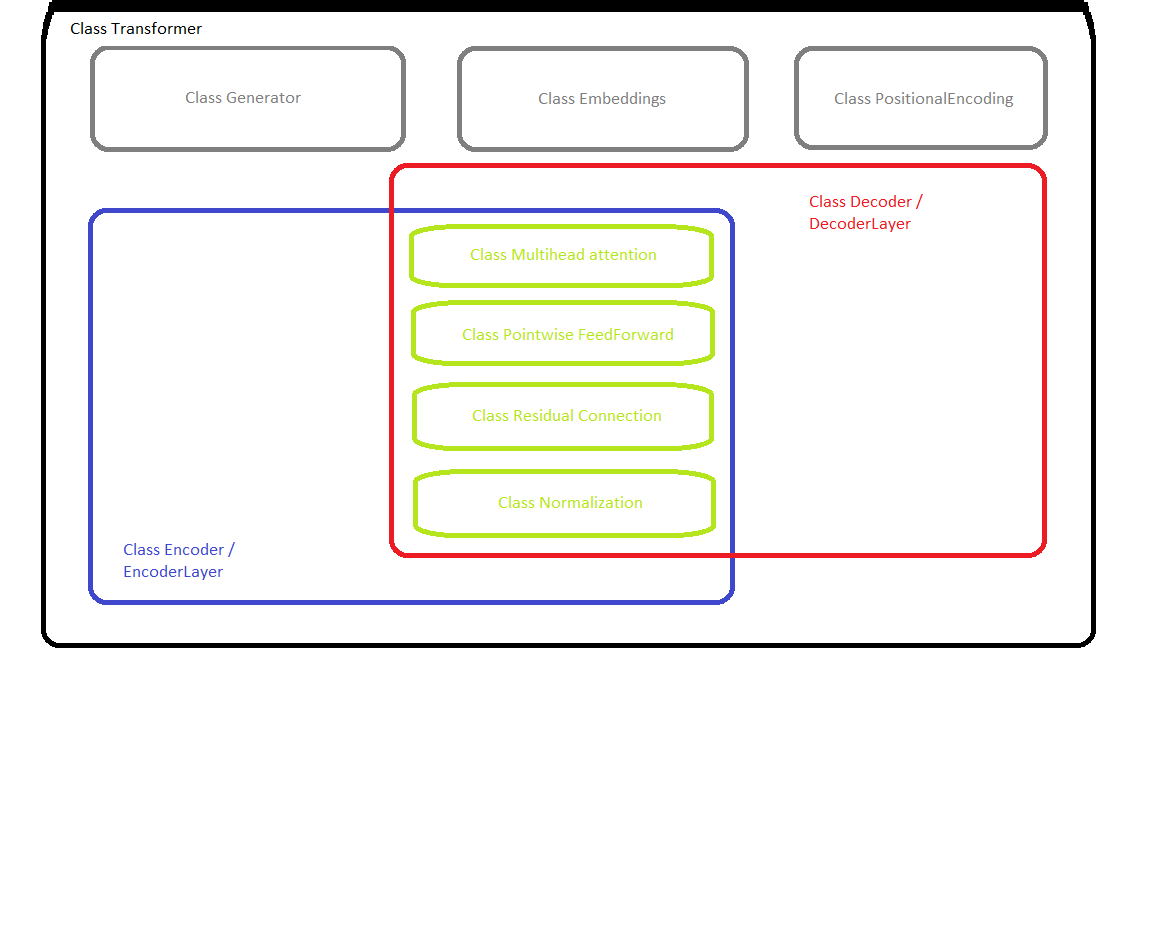

In [ ]:
from IPython.display import Image
Image(filename='/content/AnnotedTransformer Class Structure.png',width=700, height=600)

*It is important to notice this is not the only structure one can follow to design the algorithm. For example, the attention mechanism, which is defined as function here, could also be implemented as a class, and multi-head attention could just be a function that stacks attention objects. 

What this diagram is telling us is whis are the most repeated modules across the architecture. For example, looking at the center of the diagram, one can see how both, the Encoder module and the Decoder module, make use of the Multi-head Attention and the Point-wise feed forward modules, but as we will see the attention used will be different. And so on.

## Architecture
In this section I will go over the architecture of a transformer step by step. I will follow the Annoted Transformer by Harvard NLP, adding the pseudocode and Tensorflow/Keras translation:

In [ ]:
#Imports for Harvard PyTorch implementation
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

And for the newer version:

In [ ]:

import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

In [ ]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`. 
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 19 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,383 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 6s (74.6 MB/s)
(Reading database ... 128126 files and directories currently installed.)
Removing libcudnn8-dev (8.4.0.27-1+cuda11.6) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.4.0.27-1+cuda11.6 to

In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

Alright. What I am going to do first is creating the inner classes of the transformer, that is, the most repeated modules. First, I will use PyTorch and then I will use TF.

### Normalization layer

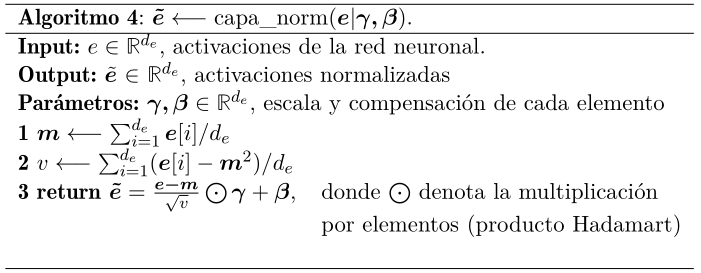

In [ ]:
from IPython.display import Image
Image(filename='/content/capa_norm.png',width=500,height=200)

In [ ]:
 ##Pytorch
 class CapaNorm(nn.Module):
  """
  Se construye un modulo capa de normalización.
  """
  def __init__(self, caracteristicas,eps=1e-6):
    super(CapaNorm, self).__init__()
    self.a_2=nn.Parameter(torch.ones(caracteristicas))
    self.b_2=nn.Parameter(torch.zeros(caracteristicas))
    self.eps=eps

  def forward(self,x):
    mean=x.mean(-1,keepdim=True)
    std=x.std(-1,keepdim=True)
    return self.a_2*(x-mean)/(std+self.eps)+self.b_2

In [ ]:
##TEnsorFlow

class CapaNorm(tf.keras.layers.Layer):
    """
    Se construye un modulo capa de normalización.
    """
    def __init__(self, caracteristicas, eps=1e-6):
        super().__init__()
        self.a_2 = tf.Variable(tf.ones([caracteristicas]), trainable=True)
        self.b_2 = tf.Variable(tf.zeros([caracteristicas]), trainable=True)
        self.eps = eps

    def call(self, x):
        mean = tf.reduce_mean(x, axis=-1, keepdims=True)
        std = tf.math.reduce_std(x, axis=-1, keepdims=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2



### Conexión residual

In [ ]:
class ConexionSubCapa(nn.Module):
  """
  Una conexión residual seguida de una capa de normalización. 
  """

  def __init__(self, tamaño, dropout):
    super(ConexionSubCapa,self).__init__()
    norm=CapaNorm(tamaño)
    self.dropout=nn.Dropout(dropout)

  def forward(self, x, subcapa):
    "Aplica conexion residual a cualquier sub capa con el mismo tamaño."
    return x + self.dropout(subcapa(self.norm(x)))

In [ ]:
class ConexionSubCapa(tf.keras.layers.Layer):
    """
    Una conexión residual seguida de una capa de normalización.
    """

    def __init__(self, tamaño, dropout):
        super().__init__()
        self.norm = CapaNorm(tamaño)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, subcapa):
        "Aplica conexion residual a cualquier sub capa con el mismo tamaño."
        return x + self.dropout(subcapa(self.norm(x)))


As we can see, the class conexion subcap is dependant on CapaNorm. 

Next thing needed are the PFF and the MultiHead attention modules. For that I first have to define the attention mechanism. 

###Attention

The attention mechanism is the core building block of a transformer. They way it works is based on classical information retrieval techniques (therefore the query, key and value names). Basically, what it does for a single token is taking its representation (the representation compute from the embbeding+positional encoding) and a context defined by the representations of other tokens. Then it learns a linear projection from the token where the attention is applied to a vector called query for each of the tokens' representations in the context. For each of these tokens representation it also learns a linear projection to 2 vectors know as key and value. Supposely, one encaptures sintactical relationships while the other goes deeper into the semantics, but as far as I know, there is no real evidence of this. with the learned representations it does a couple of computations to add to the input token some information about its context, getting context representation as an output.

For a single token, the attention mechanism follows the next pseudocode:

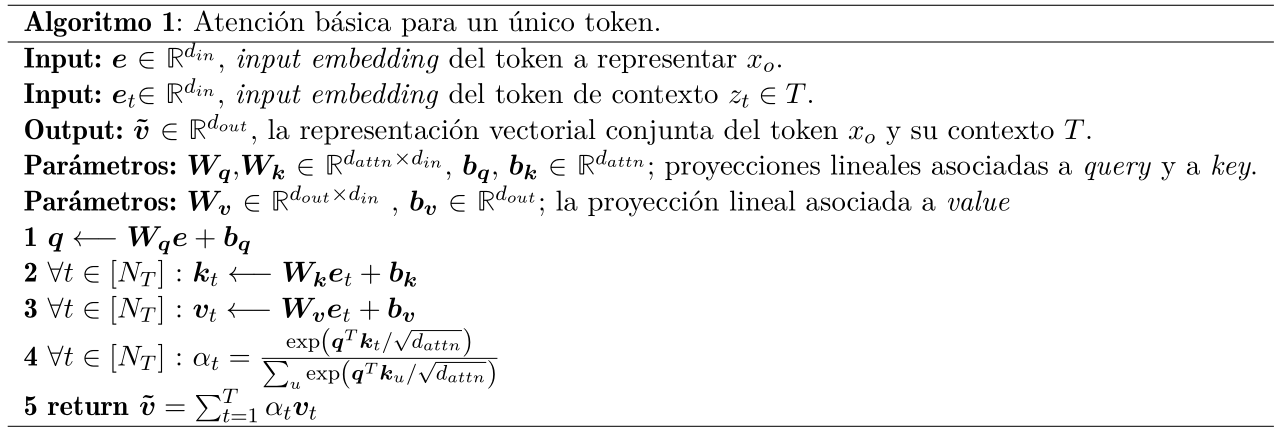

In [ ]:
from IPython.display import Image
Image(filename='/content/Single-token-attention.png',width=850, height=250)

Now, generally speaking attention is applied to a sequence of tokens. It is convinient at this point to define a primary sequence and a context sequence. I already talked about the context sequence but never mentioned as a sequence before. For applying attention to just one token it seemed redundant. But now, there is an input sequence of tokens, so I feel like expecifying is needed for clearance. There are several typs of attention depending on how we choose our primary and context sequences, and also on to which tokens on them we pay attention to:

1) Bi-directional self-attention: Primary and context sequences are the same, and for each token, its context consists on every other token in the sequence. This is the attention applied in the Encoder, and what models (Encoder-only) like BERT (Bidirectional Encoder Representations from Transformers) are baseed on.
2) Uni-directional self-attention: Now instead of the context being the whole sentence, we have that for each token the context are only the previous ones. The first attention block on a decoder is this type of attention. GPT like models belong to the type of models (Decoder-only) making use of only this type of attention, and thats why they are solely trained based on the task of predictiong the next token.
3) Cross-attention: Primary and context sequences are different. This is the type of attention applied at the union of an Encoder and a Decoder. In that case the primary sequence of token would be the original sentence, and the context for each token would come given by the predicted sequence to that point.

Usually, in a transformer you dont really have a block of a single attention. Rather you have "heads" of attention. The whole block is usually called Multi-head attention.


As for the masking, it is important to point out that its not the same type of masking as its done to the input for running the whole transformer. This one is done with a function mask on each loop of the neural network.

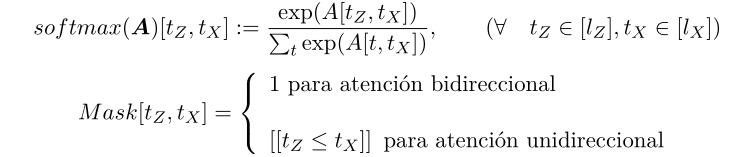

In [ ]:
from IPython.display import Image
Image(filename='/content/masking and softmax.png',width=600, height=120)

In [ ]:
def MaskUnidireccional(tamaño):
  attn_shape=(1,tamaño,tamaño)
  mask=np.triu(np.ones(attn_shape),k=1).astype('uint8')
  return torch.from_numpy(mask)==0

In [ ]:
def MaskUnidireccional(tamaño):
  attn_shape = (1, tamaño, tamaño)
  mask = 1 - tf.linalg.band_part(tf.ones(attn_shape), -1, 0)
  return mask

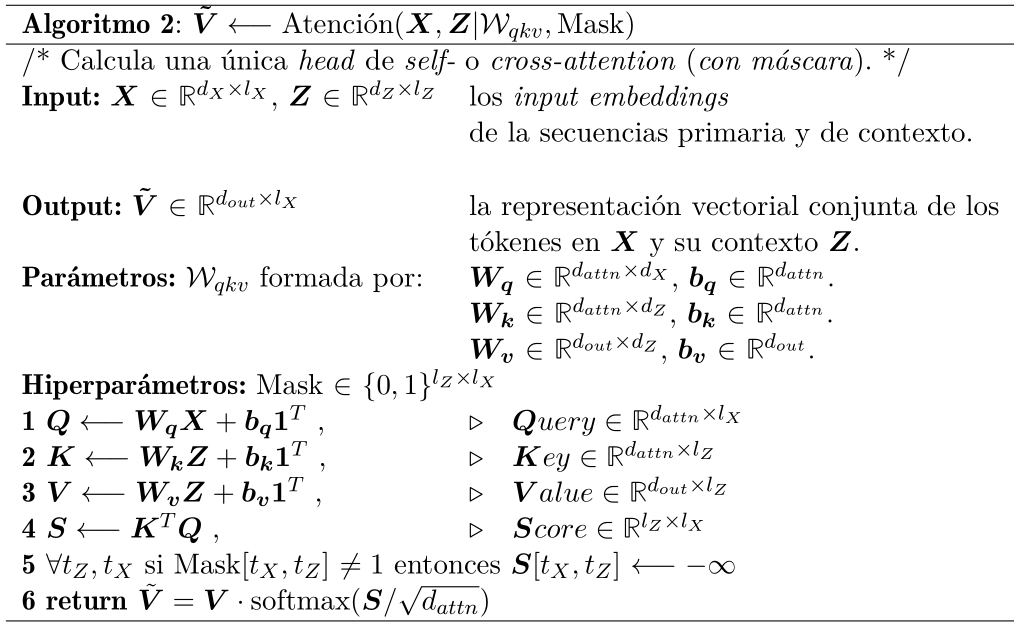

In [ ]:
from IPython.display import Image
Image(filename='/content/sequence-attention.png',width=650, height=350)

For this code, I will suppose Query, Key and value vectors are mapped previously to applying attention, thats why instead of reciving as arguments the primary and context sequences the function gets query, key and value directly. Therefore, I only need to compute the scores, set up the masking if having unidirectional attention and return value*softmax(scores).

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
  d_k=query.size(-1)
  scores=torch.matmul(query,key.transpose(-2,-1)) / math.sqrt(d_k)
  if mask is not None:
    scores=scores.masked_fill(mask==0,-1e9)
    p_attn=F.softmax(scores,dim=-1)
  if dropout is not None:
    p_attn=dropout(p_attn)
  return torch.matmul(p_attn,value),p_attn

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = tf.shape(query)[-1]
    scores = tf.matmul(query, key, transpose_b=True) / math.sqrt(d_k)
    if mask is not None:
        scores = tf.where(mask == 0, -1e9, scores)
        p_attn = tf.nn.softmax(scores, axis=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return tf.matmul(p_attn, value), p_attn

Now, this would be just one of the heads used in every attention block. The full multi-head algorithm would look something like:

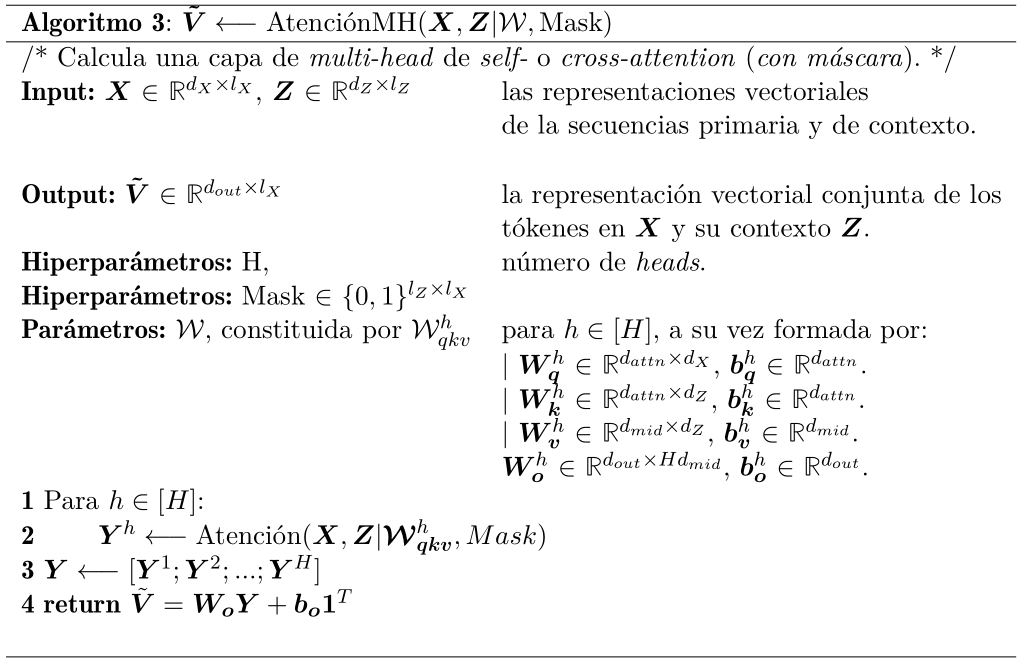

In [ ]:
from IPython.display import Image
Image(filename='/content/multi-head-attention.png',width=650, height=400)

This is a little tricky. To performe to projections to the query, key and value vectors, the primary sequence is passed through the forward layer once (for the query vector) and the context sequence is passed twice (for the key and value vectors). The arguments are called query, key and value but in truth they are the input enveddings of the corresponding sequence. In case of being self-attention the input sequence will be introduce 3 times.

In [ ]:
class MultiHeadedattention(nn.Module):
  def __init__(self,h,d_model,dropout=0.1):
    super(MultiHeadedattention,self).__init__()
    assert d_model % h ==0 
    self.d_k=d_model//h
    self.h=h
    self.linears=clones(nn.Linear(d_model,d_model),4)
    self.attn=None
    self.dropout=nn.Dropout(p=dropout)

  def forward(self, query, key, value, mask=None):
    if mask is not None:
      mask=mask.unsqueeze(1)
    nbatches=query.size(0)
  # 1) hacer todas las proyecciones lineales en lotes desde d_model => h x d_k
    query,key,value= [l(x).view(nbatches,-1,self.h, self.d_k).transpose(1,2) for l,x in zip(self.linears,(query,key,value))]
  # 2) Aplicar el mecanismod e atención en todos los vectores proyectdos por lotes.
    x, self.attn=attention(query,key,value,mask=mask,dropout=self.dropout)
  # 3) Concatenar utilizando un view y aplicar la capa lineal final.
    x=x.transpose(1,2).contiguous().view(nbatches,-1,self.h*self.d_k)

    return self.linears[-1](x)

In [ ]:
class MultiHeadedAttention(tf.keras.layers.Layer):
  def __init__(self, h, d_model, dropout=0.1):
    super(MultiHeadedAttention, self).__init__()
    assert d_model % h == 0 
    self.d_k = d_model // h
    self.h = h
    self.linears = [tf.keras.layers.Dense(d_model) for _ in range(4)]
    self.attn = None
    self.dropout = tf.keras.layers.Dropout(rate=dropout)

  def call(self, query, key, value, mask=None):
    if mask is not None:
      mask = tf.expand_dims(mask, axis=1)
    nbatches = tf.shape(query)[0]
    # 1) hacer todas las proyecciones lineales en lotes desde d_model => h x d_k
    query, key, value = [l(x) for l, x in zip(self.linears, (query, key, value))]
    query = tf.reshape(query, (nbatches, -1, self.h, self.d_k))
    key = tf.reshape(key, (nbatches, -1, self.h, self.d_k))
    value = tf.reshape(value, (nbatches, -1, self.h, self.d_k))
    query = tf.transpose(query, (0, 2, 1, 3))
    key = tf.transpose(key, (0, 2, 1, 3))
    value = tf.transpose(value, (0, 2, 1, 3))
    
    x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

    x = tf.transpose(x, (0, 2, 1, 3))
    x = tf.reshape(x, (nbatches, -1, self.h * self.d_k))
    return self.linears[-1](x)


###Pointwise Feed Forward
The other important block after each multi-head attention  (and its respective add & norm) is the pointwise feed forward.

In [ ]:
from IPython.display import Image
Image(filename='/content/pointwisefeedforwardeq.png')

In [ ]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self,d_model,d_ff,dropout=0.1):
    super(PositionwiseFeedForward,self).__init__()
    self.w_1=nn.Linear(d_model,d_ff)
    self.w_2=nn.Linear(d_ff,d_model)
    self.dropout=nn.Dropout(dropout)

  def forward(self,x):
    return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [ ]:
class PositionwiseFeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x):
        return self.w_2(self.dropout(self.w_1(x)))



###Encoder


Before I start building the Encoder an the Decoder, is worth noticing that in fact, the original transformers overlap several of these blocks, so a clonning function is defined.

In [ ]:
def clones(module,N):
  """
  Produce N capas idénticas.
  """
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

As for the translation of this to tf, I have my doubts about the efficiency. In fact, to be completely honest, in the transformer published by the tensorflow team they don't follow this structure.

In [ ]:
import copy

def clones(module, N):
    """
    Produce N identical layers.
    """
    return [copy.deepcopy(module) for _ in range(N)]

Each of the layers of the encoder is made of one block of multi-headed bi-directional self-attention and one block of position wise feed forward, with a normalization and a residual connection applied on each of them. 

In [ ]:
class CapaEncoder(nn.Module):
  def __init__(self,tamaño,self_attn,PFF,dropout):
    super(CapaEncoder,self).__init__()
    self.self_attn=self_attn
    self.PFF=PFF
    self.subcapa=clones(ConexionSubCapa(tamaño,dropout),2)
    self.tamaño=tamaño

  def forward(self, x,mask):
    x=self.subcapa[0](x,lambda x: self.self_attn(x,x,x,mask))
    return self.subcapa[1](x, self.PFF)

In [ ]:
class CapaEncoder(tf.keras.layers.Layer):
  def __init__(self, tamaño, self_attn, PFF, dropout):
    super(CapaEncoder, self).__init__()
    self.self_attn = self_attn
    self.PFF = PFF
    self.subcapa = [ConexionSubCapa(tamaño, dropout) for _ in range(2)]
    self.tamaño = tamaño

  def call(self, x, mask):
    x = self.subcapa[0](x, lambda x: self.self_attn(x, x, x, mask))
    return self.subcapa[1](x, self.PFF)


Therefore, the whole encoder would look something like:

In [ ]:
class Encoder(nn.Module):
  """
  El núcleo del encoder es un stack de N capas
  """
  def __init__(self,capa,N):
    super(Encoder, self).__init__()
    self.capas = clones(capa,N)
    self.norm= CapaNorm(capa.size)

  def forward(self,x,mask):
    """
    Pasa el input (y máscara) a traves de cada capa en respuesta.
    """
    for capa in self.capas:
      x=capa(x,mask)
    return self.norm(x)

In [ ]:
class Encoder(tf.keras.layers.Layer):
  """
  El núcleo del encoder es un stack de N capas
  """
  def __init__(self, capa, N):
    super(Encoder, self).__init__()
    self.capas = [capa for _ in range(N)]
    self.norm = CapaNorm(capa.tamaño)

  def call(self, x, mask):
    """
    Pasa el input (y máscara) a traves de cada capa en respuesta.
    """
    for capa in self.capas:
      x = capa(x, mask)
    return self.norm(x)

###Decoder

For the decoder there are 2 attention blocks, first one being a uni-directional multi-headed-self-attention block, and the second one being a multiheaded cross-attention block. They are followed by a PFF module and, as always, each of them haver therin own normalizations and residual connection.

In [ ]:
class CapaDecoder(nn.Module):

  def __init__(self, tamaño, self_attn, cross_attn, PFF, dropout):
    super(CapaDecoder,self).__init__()
    self.tamaño=tamaño
    self.self_attn=self_attn
    self.cross_attn=cross_attn
    self.PFF=PFF
    self.subcapa=clones(ConexionSubCapa(tamaño,dropout),3)

  def forward(self,x,memoria,ori_mask,obj_mask):
    m=memoria
    x=self.subcapa[0](x, lambda x: self.self_atten(x,x,x,obj_mask))
    x=self.subcapa[1](x, lambda x: self.ori_mask(x,m,m, ori_mask))
    return self.subcapa[2](x,self.PFF)

In [ ]:
class CapaDecoder(tf.keras.layers.Layer):

  def __init__(self, tamaño, self_attn, cross_attn, PFF, dropout):
    super(CapaDecoder,self).__init__()
    self.tamaño = tamaño
    self.self_attn = self_attn
    self.cross_attn = cross_attn
    self.PFF = PFF
    self.subcapa = [ConexionSubCapa(tamaño, dropout) for _ in range(3)]

  def call(self, x, memoria, ori_mask, obj_mask):
    m = memoria
    x = self.subcapa[0](x, lambda x: self.self_attn(x, x, x, obj_mask))
    x = self.subcapa[1](x, lambda x: self.cross_attn(x, m, m, ori_mask))
    return self.subcapa[2](x, self.PFF)

And the full decoder:

In [ ]:
class Decoder(nn.Module):
  """
  Decoder genérico con N capas y máscara.
  """
  def __init__(self, capa,N):
    super(Decoder,self).__init__()
    self.capas=clones(capa,N)
    self.norm=CapaNorm(capa.size)

  def forward(self,x, memoria, ori_mask, obj_mask):
    for capa in self.capas:
      x=capa(x,memoria,ori_mask,obj_mask)
    return self.norm(x)

In [ ]:
class CapaDecoder(tf.keras.layers.Layer):

  def __init__(self, tamaño, self_attn, cross_attn, PFF, dropout):
    super(CapaDecoder,self).__init__()
    self.tamaño = tamaño
    self.self_attn = self_attn
    self.cross_attn = cross_attn
    self.PFF = PFF
    self.subcapa = [ConexionSubCapa(tamaño, dropout) for _ in range(3)]

  def call(self, x, memoria, ori_mask, obj_mask):
    m = memoria
    x = self.subcapa[0](x, lambda x: self.self_attn(x, x, x, obj_mask))
    x = self.subcapa[1](x, lambda x: self.cross_attn(x, m, m, ori_mask))
    return self.subcapa[2](x, self.PFF)


###Encoder-Decoder


In [ ]:
class EncoderDecoder(nn.Module):
  """
  Arquitectura estándar Codificador-Decodificador. 
  """

  def __init__(self, encoder, decoder, ori_embed, obj_embed, generator):
    super(EncoderDecoder,self).__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.ori_embed=ori_embed
    self.obj_embed=obj_embed
    self.generator=generator

  def forward(self,ori,obj,ori_mask,obj_mask):
    "Ingerir y procesar la seqcuencia de origen y la objetivo"
    return self.decode(self.encode(ori,ori_mask),ori_mask,obj,obj_mask)

  def encode(self, ori, ori_mask):
    return self.encoder(self, ori, ori_mask)

  def decode(self,memory, ori_mask, obj, obj_mask):
    return self.decoder(self.obj_embed(obj), memory, ori_mask, obj_mask)

In [ ]:
class EncoderDecoder(nn.Module):
  """
  Arquitectura estándar Codificador-Decodificador. 
  """

  def __init__(self, encoder, decoder, ori_embed, obj_embed, generator):
    super(EncoderDecoder,self).__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.ori_embed=ori_embed
    self.obj_embed=obj_embed
    self.generator=generator

  def forward(self,ori,obj,ori_mask,obj_mask):
    "Ingerir y procesar la seqcuencia de origen y la objetivo"
    return self.decode(self.encode(ori,ori_mask),ori_mask,obj,obj_mask)

  def encode(self, ori, ori_mask):
    return self.encoder(self, ori, ori_mask)

  def decode(self,memory, ori_mask, obj, obj_mask):
    return self.decoder(self.obj_embed(obj), memory, ori_mask, obj_mask)

###Word embeddings

Before  being processed by the encoder-decoder, tokens are embbeded on a contex-free representation. That can be based on tf-idf representations over dictionaries or dl frameworks like word2vec.

In [ ]:
class Embeddings(nn.Module):

  def __init__(self, d_model, vocab):
    super(Embeddings,self).__init__()
    self.lut=nn.Embedding(vocab,d_model)
    self.d_model=d_model

  def forward(self,x):
    return self.lut(x)*math.sqrt(self.d_model)

In [ ]:
class Embeddings(tf.keras.layers.Layer):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = tf.keras.layers.Embedding(vocab, d_model)
        self.d_model = d_model

    def call(self, x):
        return self.lut(x) * tf.math.sqrt(self.d_model)

###Positional Encoding

However, since representing contex in somehow linked to the sitactics and, therefore, the order of the words withing a sentence, it is needed to include some information about position for hte transformers to learn. THe way they came across in the Attention is all you need paper is by hard-coding a positional encoding. This encoding could also be learned, but it won't be the case on this notebook. The formula they used in the original paper was:

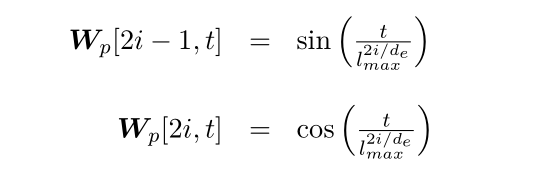

In [ ]:
from IPython.display import Image
Image(filename='/content/positional-encoding.png')

Usually, the input embeding is sum of the context-free original embeding and the positional encoding:

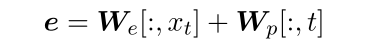

In [ ]:
from IPython.display import Image
Image(filename='/content/input_embedding.png')

In [ ]:
class PositionalEncoding(nn.Module):

  def __init__(self,d_model,dropout,max_len=5000):
    super(PositionalEncoding,self).__init__()
    self.dropout=nn.Dropout(p=dropout)

    #Calcula los positional encodings una vez en el espacio logarítmico
    pe=torch.zeros(max_len, d_model)
    position=torch.arange(0,max_len).unsqueeze(1)
    div_term=torch.exp(torch.arange(0,d_model,2)*
                       -(math.log(10000.0)/d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)
        
  def forward(self, x):
    x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
    return self.dropout(x)


In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = tf.keras.layers.Dropout(rate=dropout)

        # Calcula los positional encodings una vez en el espacio logarítmico
        pe = np.zeros((max_len, d_model))
        position = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[np.newaxis, ...]
        self.pe = tf.constant(pe, dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        x = x + self.pe[:, :seq_len, :]
        return self.dropout(x)


###Unembedding (mapping into vocab)
Finally, we need to map the output of the decoder into a value that gives us the token we intend to predict.

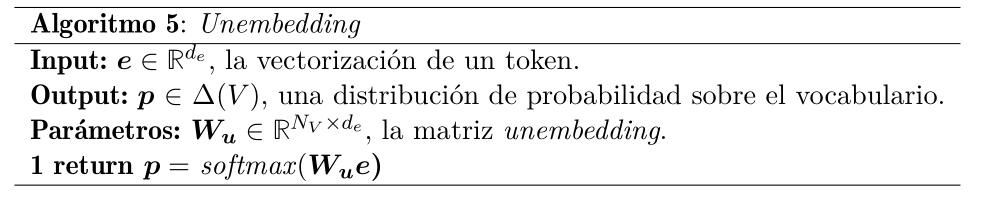

In [ ]:
from IPython.display import Image
Image(filename='/content/Unembedding.png')

In [ ]:
class Unembedding(nn.Module):
  """
  se define el paso Feed Forward
  """
  def __init__(self, d_model, vocab):
    super(Unembedding, self).__init__()
    self.proj=nn.Linear(d_model,vocab)

  def forward(self,x):
    return F.log_softmax(self.proj(x),dim=-1)

In [ ]:
class Unembedding(tf.keras.layers.Layer):
  def __init__(self, d_model, vocab):
    super(Unembedding, self).__init__()
    self.proj = tf.keras.layers.Dense(vocab)

  def call(self, x):
    return tf.nn.log_softmax(self.proj(x), axis=-1)

###Complete model

Now, to get the whole transformer, we need to instanciate de EncoderDecoder class, passing as inputs for its arguments instances of the respective classes. We also initialize the paramenter with Golot's formula (taking into account their variance distribution) in order to avoid vanishig or exploding gradients.

In [ ]:
def make_model(
    ori_vocab, obj_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedattention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(CapaEncoder(d_model, c(attn), c(ff), dropout), N),
        Decoder(CapaDecoder(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, ori_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, obj_vocab), c(position)),
        Unembedding(d_model, obj_vocab),
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

As for the Tf implementation, I am still working on it. This code was originally intended for PyTorch, therefore a copy of modules like the one on the "copydecopy" is a bit tricky. Also, the right way of implementing this transformer would be by using TFX. I definetly need to further research into it.

## Trainning

Well. This is the point where it becomes more of software engenering problem. For nthe tiem being, I am just going to stick to the original PyTorch implementation, but it would be nice to consider using a TFX framework with this architecture.

###Batches and Masking

The idea is constructing an object that holds both the source and target sentences, as well as the construction of the masks for training (not the masks for attention).

In [ ]:
class Batch:

  def __init__(self, ori, obj=None, pad=2):  # 2 = <blank>
        self.ori = ori
        self.ori_mask = (ori != pad).unsqueeze(-2)
        if obj is not None:
            self.obj = obj[:, :-1]
            self.obj_y = obj[:, 1:]
            self.obj_mask = self.make_std_mask(self.obj, pad)
            self.ntokens = (self.obj_y != pad).data.sum()

    @staticmethod
    def make_std_mask(obj, pad):
        "Create a mask to hide padding and future words."
        obj_mask = (obj != pad).unsqueeze(-2)
        obj_mask = obj_mask & subsequent_mask(obj.size(-1)).type_as(
            obj_mask.data
        )
        return obj_mask

IndentationError: ignored

###Trainning loop
Basically a function that recieves as inputs a model (object from the class model), a loss_compute (object from one of the loss classes that will be defined later on), and dictionary data_iter with info about the iteration and the batch of data for the trainning epooch.  
"Next we create a generic training and scoring function to keep track of loss. We pass in a generic loss compute function that also handles parameter updates."




In [ ]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In the newer version:

In [ ]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

In [ ]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

###Hardware and schedule
As far as I understand it, the authors made use of aws services for the training. I still need to figure out this part though:

"We trained our models on one machine with 8 NVIDIA P100 GPUs. For our base models using the hyperparameters described throughout the paper, each training step took about 0.4 seconds. We trained the base models for a total of 100,000 steps or 12 hours. For our big models, step time was 1.0 seconds. The big models were trained for 300,000 steps (3.5 days)."

###Optimizer
They used an Adam optimizer with $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{-9}$. The fun part is that they varied the learning rate over the course of trainning following a formula that increses linearly that value for the first $warmup\_ steps$ and and decreases it afterwards proportionally to inverse squared root of the step number. For Vision Transformers, the classical way of varying the learning rate was more abrupt (instead of gradual increase/decrease like in NLP):

$$
lrate=d_{model}^{-0.5}\cdot min(step_num^{-0.5}, step\_num \cdot warmup\_steps^{-1.5})
$$

They used $warmup_steps=4000$.



In [ ]:
class NoamOpt:
  "Implements the varying learning rate for the optimizer"
  def __init__(self,model_size,factor,warmup,optimizer):
    self.optimizer=optimizer
    self.model_size=model_size
    self.factor=factor
    self.warmup=warmup
    self._step=0
    self._rate=0
  
  def step(self):
    "Updates parameters and rate"
    self._step += 1
    rate = self.rate()
    for p in self.optimizer.param_groups:
      p['lr'] = rate
    self._rate = rate
    self.optimizer.step()

  def rate(self, step = None):
    "This is where the updated lrate is defined"
    if step is None:
      step = self._step
    return self.factor * (self.model_size ** (-0.5) * min (step ** (-0.5), step * self.warmup ** (-1.5)))

def get_std_opt(model):
  return NoamOpt(model.ori_embed[0].d_model,2,4000, torch.optim.Adam(model.parameters() , lr=0, betas=(0.9,0.98), eps=1e-9))

The newer version makes use of a newer feature in PyTorch called LambdaLR that allows you to define a step function for varying learning rates given an optimizer (Adam in this case). Either way is fine:

In [ ]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [ ]:
def example_learning_schedule():
    opts = [
        [512, 1, 4000],  # example 1
        [512, 1, 8000],  # example 2
        [256, 1, 4000],  # example 3
    ]

    dummy_model = torch.nn.Linear(1, 1)
    learning_rates = []

    # we have 3 examples in opts list.
    for idx, example in enumerate(opts):
        # run 20000 epoch for each example
        optimizer = torch.optim.Adam(
            dummy_model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9
        )
        lr_scheduler = LambdaLR(
            optimizer=optimizer, lr_lambda=lambda step: rate(step, *example)
        )
        tmp = []
        # take 20K dummy training steps, save the learning rate at each step
        for step in range(20000):
            tmp.append(optimizer.param_groups[0]["lr"])
            optimizer.step()
            lr_scheduler.step()
        learning_rates.append(tmp)

    learning_rates = torch.tensor(learning_rates)

    # Enable altair to handle more than 5000 rows
    alt.data_transformers.disable_max_rows()

    opts_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Learning Rate": learning_rates[warmup_idx, :],
                    "model_size:warmup": ["512:4000", "512:8000", "256:4000"][
                        warmup_idx
                    ],
                    "step": range(20000),
                }
            )
            for warmup_idx in [0, 1, 2]
        ]
    )

    return (
        alt.Chart(opts_data)
        .mark_line()
        .properties(width=600)
        .encode(x="step", y="Learning Rate", color="model_size:warmup:N")
        .interactive()
    )


example_learning_schedule()

###Regularization
####Label Smoothing
This is completely new ground for me at the moment. In the words of the authors:

"During training, we employed label smoothing of value $\epsilon=0.1. This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score. 

We implement label smoothing using the KL div loss. Instead of using a one-hot target distribution, we create a distribution that has confidence of the correct word and the rest of the smoothing mass distributed throughout the vocabulary."

From what I see Its basically another layer to distribute the probabilities across the whole vocabulary (I am fairly new to this so this is the first time I see this technique).

In [ ]:
class LabelSmoothing(nn.Module):
  "Implement label smoothing"
  def __init__(self,size,padding_idx,smoothing=0.0):
    super(labelSmoothing, self).__init__()
    self.criterion = nn.KLDivLoss(size_average=False)
    self.padding_idx = padding_idx
    self.confidence = 1.0 - smoothing
    self.size = size
    self.true_dist = none
 
  def forward(self, x, target):
    assert x.size(1) == self.size
    true_dist = x.data.clone()
    true_dist.fill_(self.smoothing / (self.size - 2))
    true_dist.scatter_(1, target.data.unsqueeze(1),self.confidence)
    true_dist[:, self.padding_idx] = 0
    mask = torch.nonzero(target.data == self.padding_idx)
    if mask.dim() > 0:
        true_dist.index_fill_(0, mask.squeeze(), 0.0)
    self.true_dist = true_dist
    return self.criterion(x, Variable(true_dist, requires_grad=False))



The newer version does not use Variable():

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())

##A first example
"We can begin by trying out a simple copy-task. Given a random set of input symbols from a small vocabulary, the goal is to generate back those same symbols."



###Synthetic data

In [ ]:
def data_gen(V, batch, nbatches):
  "Generate random data for a copying task."
  for i in range(nbatches):
    data = torch.from_numpy(np.random.randint(1,V,size=(batch,10)))
    data[:,0]=1
    ori = Variable(data, requieres_grad=False)
    obj= Variable(data, requieres_grad=False)
    yield Batch(ori,obj,0)

###Loss Computation
Just a simple loss compute and train function.


In [ ]:
class SimpleLossCompute:
  def __init__(self,generator,criterion,opt=None):
    self.generator=generator
    self.criterion=criterion
    self.opt=opt

  def__call__(self,x,y,norm):
    s=self.generator(x)
    "This line of code is used to reshape the tensor x to a two-dimensional tensor."
    "The method contiguous() returns a tensor with the same data as x, but the memory is arranged in a contiguous chunk of memory."
    "This is sometimes necessary because some operations require that the memory be contiguous. "
    "The method view() is used to reshape the tensor. "
    "The first argument -1 means that the size of that dimension will be inferred from the size of the tensor and the other dimensions. "
    "The second argument x.size(-1) means that the size of the last dimension will be unchanged. "
    "So, x.contiguous().view(-1, x.size(-1)) first makes the tensor contiguous and then reshapes it to a two-dimensional "
    "tensor with as many rows as necessary to hold all the elements in x and x.size(-1) columns."
    loss = self.criterion(x.contiguous().view(-1,x.size(-1)), y.contiguous().view(-1)) / norm
    loss.backward()
    if self.opt is not None:
      self.opt.step()
      self.opt.optimizer.zero_grad()
    return loss.data[0] * norm


The newer version of the Annoted Transformer outputs the loss as well, but does not take an optimizer as input:


In [ ]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss

###Greedy Decoding

In [ ]:
#Train the simple copy task.
"https://towardsdatascience.com/the-three-decoding-methods-for-nlp-23ca59cb1e9d"
V=11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing = 0.0)
model=make_model(V,V,N=2)
model_opt = NoamOpt(model.ori_embed[0].d_model,1,400,torch.optim.Adam(model.parameters(),lr=0,betas=(0.9,0.98),eps=1e-9))

for epoch in range(10):
  model.train()
  run_epoch(data_gen(V,30,20),model, SimpleLosscompute(model.generator,criterion,model_opt))
  model.eval()
  print(run_epoch(data_gen(V,30,5),model,SimpleLossCompute(model.generator,criterion,None)))


In [ ]:
def greedy-decode(model,ori,ori_mask,max_len,start_symbol):
  memory=model.encode(ori,ori_mask)
  ys=torch.ones(1,1).fill_(start:symbol).type_as(ori.data)
  for i in range(max_len-1):
    out= model.decode(memory, ori_mask, Variable(ys), Variable(subsequent_mask(ys.size(1)).type_as(ori.data)))
    prob=model.generator(out[:,1])
    _,next_word = torch.max(prob, dim = 1)
    next_word = next_word.data[0]
    ys= torch.cat([ys, torch.ones(1,1).type_as(ori.data).fill_(next_word)], dim=1)
  return ys

model.eval()
ori=Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]))
ori_mask = Variable(torch.ones(1,1,10))
print(greedy_decode(model,ori,ori_mask,max_len=10,start_symbol=1))


In the newer version of the Annoted Transformer they wrap the trainning steps up in a function:

In [ ]:
# Train the simple copy task.


def example_simple_model():
    V = 11
    criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    model = make_model(V, V, N=2)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=400
        ),
    )

    batch_size = 80
    for epoch in range(20):
        model.train()
        run_epoch(
            data_gen(V, batch_size, 20),
            model,
            SimpleLossCompute(model.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train",
        )
        model.eval()
        run_epoch(
            data_gen(V, batch_size, 5),
            model,
            SimpleLossCompute(model.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )[0]

    model.eval()
    src = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
    max_len = src.shape[1]
    src_mask = torch.ones(1, 1, max_len)
    print(greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0))


# execute_example(example_simple_model)

##An actual translation example.

Before getting to the actual trainning implementation for this real world example, I find this article way too usefull: https://aws.amazon.com/fr/blogs/machine-learning/training-large-language-models-on-amazon-sagemaker-best-practices/?sc_channel=sm&sc_campaign=Machine_Learning&sc_publisher=LINKEDIN&sc_geo=GLOBAL&sc_outcome=awareness&sc_content=2023_ml_services&trk=machine_learning&linkId=204890307

"Now we consider a real-world example using the IWSLT German-English Translation task. This task is much smaller than the WMT task considered in the paper, but it illustrates the whole system. We also show how to use multi-gpu processing to make it really fast."

In [ ]:
#!pip install torchtext spacy
#!python -m spacy download en
#!python -m spacy download de

###Data loading

In [ ]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    ORI = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
    OBJ = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                     eos_token = EOS_WORD, pad_token=BLANK_WORD)

    MAX_LEN = 100
    train, val, test = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(ORI, OBJ), 
        filter_pred=lambda x: len(vars(x)['ori']) <= MAX_LEN and 
            len(vars(x)['obj']) <= MAX_LEN)
    MIN_FREQ = 2
    ORI.build_vocab(train.ori, min_freq=MIN_FREQ)
    OBJ.build_vocab(train.obj, min_freq=MIN_FREQ)

Again, there are some changes in the new version of the Annoted transformer. The implementation seems to be updated to the modern spacy modules:

In [ ]:
# Load spacy tokenizer models, download them if they haven't been
# downloaded already


def load_tokenizers():

    try:
        spacy_de = spacy.load("de_core_news_sm")
    except IOError:
        os.system("python -m spacy download de_core_news_sm")
        spacy_de = spacy.load("de_core_news_sm")

    try:
        spacy_en = spacy.load("en_core_web_sm")
    except IOError:
        os.system("python -m spacy download en_core_web_sm")
        spacy_en = spacy.load("en_core_web_sm")

    return spacy_de, spacy_en

In [ ]:
def tokenize(text, tokenizer):
    return [tok.text for tok in tokenizer.tokenizer(text)]


def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index])

In [ ]:
def build_vocabulary(spacy_de, spacy_en):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    print("Building German Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_src = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_de, index=0),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    print("Building English Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_en, index=1),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])

    return vocab_src, vocab_tgt


def load_vocab(spacy_de, spacy_en):
    if not exists("vocab.pt"):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
        torch.save((vocab_src, vocab_tgt), "vocab.pt")
    else:
        vocab_src, vocab_tgt = torch.load("vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt


if is_interactive_notebook():
    # global variables used later in the script
    spacy_de, spacy_en = show_example(load_tokenizers)
    vocab_src, vocab_tgt = show_example(load_vocab, args=[spacy_de, spacy_en])

###Iterators

"Batching matters a ton for speed. We want to have very evenly divided batches, with absolutely minimal padding. To do this we have to hack a bit around the default torchtext batching. This code patches their default batching to make sure we search over enough sentences to find tight batches."
https://huggingface.co/docs/transformers/pad_truncation

In [ ]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    ori, obj = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(ori, obj, pad_idx)

The is no specific class for this task in the newer version, just a couple of funtions. 

In [ ]:
def collate_batch(
    batch,
    src_pipeline,
    tgt_pipeline,
    src_vocab,
    tgt_vocab,
    device,
    max_padding=128,
    pad_id=2,
):
    bs_id = torch.tensor([0], device=device)  # <s> token id
    eos_id = torch.tensor([1], device=device)  # </s> token id
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat(
            [
                bs_id,
                torch.tensor(
                    src_vocab(src_pipeline(_src)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        processed_tgt = torch.cat(
            [
                bs_id,
                torch.tensor(
                    tgt_vocab(tgt_pipeline(_tgt)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        src_list.append(
            # warning - overwrites values for negative values of padding - len
            pad(
                processed_src,
                (
                    0,
                    max_padding - len(processed_src),
                ),
                value=pad_id,
            )
        )
        tgt_list.append(
            pad(
                processed_tgt,
                (0, max_padding - len(processed_tgt)),
                value=pad_id,
            )
        )

    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    return (src, tgt)


In [ ]:
def create_dataloaders(
    device,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    batch_size=12000,
    max_padding=128,
    is_distributed=True,
):
    # def create_dataloaders(batch_size=12000):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    def collate_fn(batch):
        return collate_batch(
            batch,
            tokenize_de,
            tokenize_en,
            vocab_src,
            vocab_tgt,
            device,
            max_padding=max_padding,
            pad_id=vocab_src.get_stoi()["<blank>"],
        )

    train_iter, valid_iter, test_iter = datasets.Multi30k(
        language_pair=("de", "en")
    )

    train_iter_map = to_map_style_dataset(
        train_iter
    )  # DistributedSampler needs a dataset len()
    train_sampler = (
        DistributedSampler(train_iter_map) if is_distributed else None
    )
    valid_iter_map = to_map_style_dataset(valid_iter)
    valid_sampler = (
        DistributedSampler(valid_iter_map) if is_distributed else None
    )

    train_dataloader = DataLoader(
        train_iter_map,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler,
        collate_fn=collate_fn,
    )
    valid_dataloader = DataLoader(
        valid_iter_map,
        batch_size=batch_size,
        shuffle=(valid_sampler is None),
        sampler=valid_sampler,
        collate_fn=collate_fn,
    )
    return train_dataloader, valid_dataloader

###Multi-GPU Trainning

In the first implementation of the Annoted Transformer, there was a whole section dedicated to this in particular. However, in the new version they just go straight up to the trainning, using the newer distributed trainning tools in PyTorch. Lets first show the older version, and in the last part of the "Trainning the System" section I will cover the latest implementation.

"Finally to really target fast training, we will use multi-gpu. This code implements multi-gpu word generation. It is not specific to transformer so I won’t go into too much detail. The idea is to split up word generation at training time into chunks to be processed in parallel across many different gpus. We do this using pytorch parallel primitives:
* replicate - split modules onto different gpus.
* scatter - split batches onto different gpus
* parallel_apply - apply module to batches on different gpus
* gather - pull scattered data back onto one gpu.
* nn.DataParallel - a special module wrapper that calls these all before evaluating."

In [ ]:
# Skip if not interested in multigpu.
class MultiGPULossCompute:
    "A multi-gpu loss compute and train function."
    def __init__(self, generator, criterion, devices, opt=None, chunk_size=5):
        # Send out to different gpus.
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion, 
                                               devices=devices)
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size
        
    def __call__(self, out, targets, normalize):
        total = 0.0
        generator = nn.parallel.replicate(self.generator, 
                                                devices=self.devices)
        out_scatter = nn.parallel.scatter(out, 
                                          target_gpus=self.devices)
        out_grad = [[] for _ in out_scatter]
        targets = nn.parallel.scatter(targets, 
                                      target_gpus=self.devices)

        # Divide generating into chunks.
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):
            # Predict distributions
            out_column = [[Variable(o[:, i:i+chunk_size].data, 
                                    requires_grad=self.opt is not None)] 
                           for o in out_scatter]
            gen = nn.parallel.parallel_apply(generator, out_column)

            # Compute loss. 
            y = [(g.contiguous().view(-1, g.size(-1)), 
                  t[:, i:i+chunk_size].contiguous().view(-1)) 
                 for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(self.criterion, y)

            # Sum and normalize loss
            l = nn.parallel.gather(loss, 
                                   target_device=self.devices[0])
            l = l.sum()[0] / normalize
            total += l.data[0]

            # Backprop loss to output of transformer
            if self.opt is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.clone())

        # Backprop all loss through transformer.            
        if self.opt is not None:
            out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad, 
                                    target_device=self.devices[0])
            o1.backward(gradient=o2)
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return total * normalize

"Now we create our model, criterion, optimizer, data iterators, and paralelization"

In [ ]:
# GPUs to use
devices = [0, 1, 2, 3]
if True:
    pad_idx = TGT.vocab.stoi["<blank>"]
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    model.cuda()
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    criterion.cuda()
    BATCH_SIZE = 12000
    train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=True)
    valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=False)
    model_par = nn.DataParallel(model, device_ids=devices)
None

"Now we train the model. I will play with the warmup steps a bit, but everything else uses the default parameters. On an AWS p3.8xlarge with 4 Tesla V100s, this runs at ~27,000 tokens per second with a batch size of 12,000"

###Training the System

The older version goes as follows:

In [ ]:
#!wget https://s3.amazonaws.com/opennmt-models/iwslt.pt

In [ ]:
if False:
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(10):
        model_par.train()
        run_epoch((rebatch(pad_idx, b) for b in train_iter), 
                  model_par, 
                  MultiGPULossCompute(model.generator, criterion, 
                                      devices=devices, opt=model_opt))
        model_par.eval()
        loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter), 
                          model_par, 
                          MultiGPULossCompute(model.generator, criterion, 
                          devices=devices, opt=None))
        print(loss)
else:
    model = torch.load("iwslt.pt")

"Once trained we can decode the model to produce a set of translations. Here we simply translate the first sentence in the validation set. This dataset is pretty small so the translations with greedy search are reasonably accurate."

In [ ]:
for i, batch in enumerate(valid_iter):
    ori = batch.ori.transpose(0, 1)[:1]
    ori_mask = (ori != ORI.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, ori, ori_mask, 
                        max_len=60, start_symbol=OBJ.vocab.stoi["<s>"])
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = OBJ.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = OBJ.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    break

As mentioned, the newer version does no include an specific Multi-GPU trainning section. The procced directly with the trainning as follows:

In [ ]:
def train_worker(
    gpu,
    ngpus_per_node,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    config,
    is_distributed=False,
):
    print(f"Train worker process using GPU: {gpu} for training", flush=True)
    torch.cuda.set_device(gpu)

    pad_idx = vocab_tgt["<blank>"]
    d_model = 512
    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.cuda(gpu)
    module = model
    is_main_process = True
    if is_distributed:
        dist.init_process_group(
            "nccl", init_method="env://", rank=gpu, world_size=ngpus_per_node
        )
        model = DDP(model, device_ids=[gpu])
        module = model.module
        is_main_process = gpu == 0

    criterion = LabelSmoothing(
        size=len(vocab_tgt), padding_idx=pad_idx, smoothing=0.1
    )
    criterion.cuda(gpu)

    train_dataloader, valid_dataloader = create_dataloaders(
        gpu,
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=config["batch_size"] // ngpus_per_node,
        max_padding=config["max_padding"],
        is_distributed=is_distributed,
    )

    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["base_lr"], betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, d_model, factor=1, warmup=config["warmup"]
        ),
    )
    train_state = TrainState()

    for epoch in range(config["num_epochs"]):
        if is_distributed:
            train_dataloader.sampler.set_epoch(epoch)
            valid_dataloader.sampler.set_epoch(epoch)

        model.train()
        print(f"[GPU{gpu}] Epoch {epoch} Training ====", flush=True)
        _, train_state = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in train_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train+log",
            accum_iter=config["accum_iter"],
            train_state=train_state,
        )

        GPUtil.showUtilization()
        if is_main_process:
            file_path = "%s%.2d.pt" % (config["file_prefix"], epoch)
            torch.save(module.state_dict(), file_path)
        torch.cuda.empty_cache()

        print(f"[GPU{gpu}] Epoch {epoch} Validation ====", flush=True)
        model.eval()
        sloss = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in valid_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )
        print(sloss)
        torch.cuda.empty_cache()

    if is_main_process:
        file_path = "%sfinal.pt" % config["file_prefix"]
        torch.save(module.state_dict(), file_path)

In [ ]:
def train_distributed_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    from the_annotated_transformer import train_worker

    ngpus = torch.cuda.device_count()
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12356"
    print(f"Number of GPUs detected: {ngpus}")
    print("Spawning training processes ...")
    mp.spawn(
        train_worker,
        nprocs=ngpus,
        args=(ngpus, vocab_src, vocab_tgt, spacy_de, spacy_en, config, True),
    )


def train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    if config["distributed"]:
        train_distributed_model(
            vocab_src, vocab_tgt, spacy_de, spacy_en, config
        )
    else:
        train_worker(
            0, 1, vocab_src, vocab_tgt, spacy_de, spacy_en, config, False
        )


def load_trained_model():
    config = {
        "batch_size": 32,
        "distributed": False,
        "num_epochs": 8,
        "accum_iter": 10,
        "base_lr": 1.0,
        "max_padding": 72,
        "warmup": 3000,
        "file_prefix": "multi30k_model_",
    }
    model_path = "multi30k_model_final.pt"
    if not exists(model_path):
        train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config)

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(torch.load("multi30k_model_final.pt"))
    return model


if is_interactive_notebook():
    model = load_trained_model()

##Training on the cloud.

Now that we have all the architecture and code to train the model, we might not have the actual hardware to do it (just by running the notebook won't do it because we only have access to a single GPU in Colab). Since I do not own a GPUs' cluster, I find relying on cloud services my best, if not my only, option. To do so, I need to modularize my code. The essiest way of doing so is to use the magic %%writefile FILENAME over the cells that I see as needed. 

"Training took 3.5 days on 8 P100 GPUs. (For the big WMT model)" So I have to be carefull about pricing.

Of course, then there is the actual engeneering problem. I need machines with multiple GPUs, which one exactly I do not know yet. Also, should I run it on VMs or in Kubernetes? In any case, the steps I will follow are:

1) Modularize the code.

2) Find an appropiate hardware in a cloud provider.

3) Run code on hardware.

I have decided that my first attempt is going to be AWS, in particular I am going to try to use the trainium service with the Neuron SDK. It allows me to use 16 chips with 2 cores each (32 cores total). It is supposed to be quite fast so hopefully it won't get passed my free 10 hours trainning tier...




###Modular code.

The way I am going to organize it is: 1) create a file .py with the transformer architecture. 2) create a training.py wich imports this architecture and trains with a single worker. 3) Create a training_1GPU.py that will make use of trainium to train on a GPU. 4) Create a distribute_training.py to run on all 32 cores.

I will actually use an AMI (Amazon Image) made by HuggingFace to use the Neuron SDK without the need to set up any dependencies.
https://www.youtube.com/watch?v=0Y5E8RI_D2E

In [10]:
%%writefile requirements.txt
!pip install -q torchdata==0.3.0 torchtext==0.12 spacy==3.2 altair GPUtil
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

Writing requirements.txt


In [7]:
%%writefile transformer.py
#Imports for Harvard PyTorch implementation
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

##Pytorch
class CapaNorm(nn.Module):
  """
  Se construye un modulo capa de normalización.
  """
  def __init__(self, caracteristicas,eps=1e-6):
    super(CapaNorm, self).__init__()
    self.a_2=nn.Parameter(torch.ones(caracteristicas))
    self.b_2=nn.Parameter(torch.zeros(caracteristicas))
    self.eps=eps

  def forward(self,x):
    mean=x.mean(-1,keepdim=True)
    std=x.std(-1,keepdim=True)
    return self.a_2*(x-mean)/(std+self.eps)+self.b_2

class ConexionSubCapa(nn.Module):
  """
  Una conexión residual seguida de una capa de normalización. 
  """

  def __init__(self, tamaño, dropout):
    super(ConexionSubCapa,self).__init__()
    norm=CapaNorm(tamaño)
    self.dropout=nn.Dropout(dropout)

  def forward(self, x, subcapa):
    "Aplica conexion residual a cualquier sub capa con el mismo tamaño."
    return x + self.dropout(subcapa(self.norm(x)))

def MaskUnidireccional(tamaño):
  attn_shape=(1,tamaño,tamaño)
  mask=np.triu(np.ones(attn_shape),k=1).astype('uint8')
  return torch.from_numpy(mask)==0

def attention(query, key, value, mask=None, dropout=None):
  d_k=query.size(-1)
  scores=torch.matmul(query,key.transpose(-2,-1)) / math.sqrt(d_k)
  if mask is not None:
    scores=scores.masked_fill(mask==0,-1e9)
    p_attn=F.softmax(scores,dim=-1)
  if dropout is not None:
    p_attn=dropout(p_attn)
  return torch.matmul(p_attn,value),p_attn

class MultiHeadedattention(nn.Module):
  def __init__(self,h,d_model,dropout=0.1):
    super(MultiHeadedattention,self).__init__()
    assert d_model % h ==0 
    self.d_k=d_model//h
    self.h=h
    self.linears=clones(nn.Linear(d_model,d_model),4)
    self.attn=None
    self.dropout=nn.Dropout(p=dropout)

  def forward(self, query, key, value, mask=None):
    if mask is not None:
      mask=mask.unsqueeze(1)
    nbatches=query.size(0)
  # 1) hacer todas las proyecciones lineales en lotes desde d_model => h x d_k
    query,key,value= [l(x).view(nbatches,-1,self.h, self.d_k).transpose(1,2) for l,x in zip(self.linears,(query,key,value))]
  # 2) Aplicar el mecanismod e atención en todos los vectores proyectdos por lotes.
    x, self.attn=attention(query,key,value,mask=mask,dropout=self.dropout)
  # 3) Concatenar utilizando un view y aplicar la capa lineal final.
    x=x.transpose(1,2).contiguous().view(nbatches,-1,self.h*self.d_k)

    return self.linears[-1](x)

class PositionwiseFeedForward(nn.Module):
  def __init__(self,d_model,d_ff,dropout=0.1):
    super(PositionwiseFeedForward,self).__init__()
    self.w_1=nn.Linear(d_model,d_ff)
    self.w_2=nn.Linear(d_ff,d_model)
    self.dropout=nn.Dropout(dropout)

  def forward(self,x):
    return self.w_2(self.dropout(F.relu(self.w_1(x))))

def clones(module,N):
  """
  Produce N capas idénticas.
  """
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class CapaEncoder(nn.Module):
  def __init__(self,tamaño,self_attn,PFF,dropout):
    super(CapaEncoder,self).__init__()
    self.self_attn=self_attn
    self.PFF=PFF
    self.subcapa=clones(ConexionSubCapa(tamaño,dropout),2)
    self.tamaño=tamaño

  def forward(self, x,mask):
    x=self.subcapa[0](x,lambda x: self.self_attn(x,x,x,mask))
    return self.subcapa[1](x, self.PFF)

class Encoder(nn.Module):
  """
  El núcleo del encoder es un stack de N capas
  """
  def __init__(self,capa,N):
    super(Encoder, self).__init__()
    self.capas = clones(capa,N)
    self.norm= CapaNorm(capa.size)

  def forward(self,x,mask):
    """
    Pasa el input (y máscara) a traves de cada capa en respuesta.
    """
    for capa in self.capas:
      x=capa(x,mask)
    return self.norm(x)

class CapaDecoder(nn.Module):

  def __init__(self, tamaño, self_attn, cross_attn, PFF, dropout):
    super(CapaDecoder,self).__init__()
    self.tamaño=tamaño
    self.self_attn=self_attn
    self.cross_attn=cross_attn
    self.PFF=PFF
    self.subcapa=clones(ConexionSubCapa(tamaño,dropout),3)

  def forward(self,x,memoria,ori_mask,obj_mask):
    m=memoria
    x=self.subcapa[0](x, lambda x: self.self_atten(x,x,x,obj_mask))
    x=self.subcapa[1](x, lambda x: self.ori_mask(x,m,m, ori_mask))
    return self.subcapa[2](x,self.PFF)
class Decoder(nn.Module):
  """
  Decoder genérico con N capas y máscara.
  """
  def __init__(self, capa,N):
    super(Decoder,self).__init__()
    self.capas=clones(capa,N)
    self.norm=CapaNorm(capa.size)

  def forward(self,x, memoria, ori_mask, obj_mask):
    for capa in self.capas:
      x=capa(x,memoria,ori_mask,obj_mask)
    return self.norm(x)

class EncoderDecoder(nn.Module):
  """
  Arquitectura estándar Codificador-Decodificador. 
  """

  def __init__(self, encoder, decoder, ori_embed, obj_embed, generator):
    super(EncoderDecoder,self).__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.ori_embed=ori_embed
    self.obj_embed=obj_embed
    self.generator=generator

  def forward(self,ori,obj,ori_mask,obj_mask):
    "Ingerir y procesar la seqcuencia de origen y la objetivo"
    return self.decode(self.encode(ori,ori_mask),ori_mask,obj,obj_mask)

  def encode(self, ori, ori_mask):
    return self.encoder(self, ori, ori_mask)

  def decode(self,memory, ori_mask, obj, obj_mask):
    return self.decoder(self.obj_embed(obj), memory, ori_mask, obj_mask)

class Embeddings(nn.Module):

  def __init__(self, d_model, vocab):
    super(Embeddings,self).__init__()
    self.lut=nn.Embedding(vocab,d_model)
    self.d_model=d_model

  def forward(self,x):
    return self.lut(x)*math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):

  def __init__(self,d_model,dropout,max_len=5000):
    super(PositionalEncoding,self).__init__()
    self.dropout=nn.Dropout(p=dropout)

    #Calcula los positional encodings una vez en el espacio logarítmico
    pe=torch.zeros(max_len, d_model)
    position=torch.arange(0,max_len).unsqueeze(1)
    div_term=torch.exp(torch.arange(0,d_model,2)*
                       -(math.log(10000.0)/d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)
        
  def forward(self, x):
    x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
    return self.dropout(x)

class Unembedding(nn.Module):
  """
  se define el paso Feed Forward
  """
  def __init__(self, d_model, vocab):
    super(Unembedding, self).__init__()
    self.proj=nn.Linear(d_model,vocab)

  def forward(self,x):
    return F.log_softmax(self.proj(x),dim=-1)

def make_model(
    ori_vocab, obj_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedattention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(CapaEncoder(d_model, c(attn), c(ff), dropout), N),
        Decoder(CapaDecoder(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, ori_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, obj_vocab), c(position)),
        Unembedding(d_model, obj_vocab),
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model



Overwriting transformer.py


In [ ]:
%%writefile tranformer_training.py 
import transformer

class Batch:
  def __init__(self, ori, obj=None, pad=2):  # 2 = <blank>
        self.ori = ori
        self.ori_mask = (ori != pad).unsqueeze(-2)
        if obj is not None:
            self.obj = obj[:, :-1]
            self.obj_y = obj[:, 1:]
            self.obj_mask = self.make_std_mask(self.obj, pad)
            self.ntokens = (self.obj_y != pad).data.sum()

    @staticmethod
    def make_std_mask(obj, pad):
        "Create a mask to hide padding and future words."
        obj_mask = (obj != pad).unsqueeze(-2)
        obj_mask = obj_mask & subsequent_mask(obj.size(-1)).type_as(
            obj_mask.data
        )
        return obj_mask

class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

'''Be aware of this training function, for this will be the function I will twick when I apply the Neuron SDK.'''
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

"""The next funtions are for data loading"
def load_tokenizers():

    try:
        spacy_de = spacy.load("de_core_news_sm")
    except IOError:
        os.system("python -m spacy download de_core_news_sm")
        spacy_de = spacy.load("de_core_news_sm")

    try:
        spacy_en = spacy.load("en_core_web_sm")
    except IOError:
        os.system("python -m spacy download en_core_web_sm")
        spacy_en = spacy.load("en_core_web_sm")

    return spacy_de, spacy_en

def load_vocab(spacy_de, spacy_en):
    if not exists("vocab.pt"):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
        torch.save((vocab_src, vocab_tgt), "vocab.pt")
    else:
        vocab_src, vocab_tgt = torch.load("vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt

def tokenize(text, tokenizer):
    return [tok.text for tok in tokenizer.tokenizer(text)]


def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index])

def build_vocabulary(spacy_de, spacy_en):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    print("Building German Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_src = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_de, index=0),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    print("Building English Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_en, index=1),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])

    return vocab_src, vocab_tgt


def load_vocab(spacy_de, spacy_en):
    if not exists("vocab.pt"):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
        torch.save((vocab_src, vocab_tgt), "vocab.pt")
    else:
        vocab_src, vocab_tgt = torch.load("vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt

"""Now I create the iterators, since batching is crutial for speed"""
def collate_batch(
    batch,
    src_pipeline,
    tgt_pipeline,
    src_vocab,
    tgt_vocab,
    device,
    max_padding=128,
    pad_id=2,
):
    bs_id = torch.tensor([0], device=device)  # <s> token id
    eos_id = torch.tensor([1], device=device)  # </s> token id
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat(
            [
                bs_id,
                torch.tensor(
                    src_vocab(src_pipeline(_src)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        processed_tgt = torch.cat(
            [
                bs_id,
                torch.tensor(
                    tgt_vocab(tgt_pipeline(_tgt)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        src_list.append(
            # warning - overwrites values for negative values of padding - len
            pad(
                processed_src,
                (
                    0,
                    max_padding - len(processed_src),
                ),
                value=pad_id,
            )
        )
        tgt_list.append(
            pad(
                processed_tgt,
                (0, max_padding - len(processed_tgt)),
                value=pad_id,
            )
        )

    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    return (src, tgt)

def create_dataloaders(
    device,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    batch_size=12000,
    max_padding=128,
    is_distributed=True,
):
    # def create_dataloaders(batch_size=12000):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    def collate_fn(batch):
        return collate_batch(
            batch,
            tokenize_de,
            tokenize_en,
            vocab_src,
            vocab_tgt,
            device,
            max_padding=max_padding,
            pad_id=vocab_src.get_stoi()["<blank>"],
        )

    train_iter, valid_iter, test_iter = datasets.Multi30k(
        language_pair=("de", "en")
    )

    train_iter_map = to_map_style_dataset(
        train_iter
    )  # DistributedSampler needs a dataset len()
    train_sampler = (
        DistributedSampler(train_iter_map) if is_distributed else None
    )
    valid_iter_map = to_map_style_dataset(valid_iter)
    valid_sampler = (
        DistributedSampler(valid_iter_map) if is_distributed else None
    )

    train_dataloader = DataLoader(
        train_iter_map,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler,
        collate_fn=collate_fn,
    )
    valid_dataloader = DataLoader(
        valid_iter_map,
        batch_size=batch_size,
        shuffle=(valid_sampler is None),
        sampler=valid_sampler,
        collate_fn=collate_fn,
    )
    return train_dataloader, valid_dataloader

"""Finally, trainning the whole system"
def train_worker(
    gpu,
    ngpus_per_node,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    config,
    is_distributed=False,
):
    print(f"Train worker process using GPU: {gpu} for training", flush=True)
    torch.cuda.set_device(gpu)

    pad_idx = vocab_tgt["<blank>"]
    d_model = 512
    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.cuda(gpu)
    module = model
    is_main_process = True
    if is_distributed:
        dist.init_process_group(
            "nccl", init_method="env://", rank=gpu, world_size=ngpus_per_node
        )
        model = DDP(model, device_ids=[gpu])
        module = model.module
        is_main_process = gpu == 0

    criterion = LabelSmoothing(
        size=len(vocab_tgt), padding_idx=pad_idx, smoothing=0.1
    )
    criterion.cuda(gpu)

    train_dataloader, valid_dataloader = create_dataloaders(
        gpu,
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=config["batch_size"] // ngpus_per_node,
        max_padding=config["max_padding"],
        is_distributed=is_distributed,
    )

    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["base_lr"], betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, d_model, factor=1, warmup=config["warmup"]
        ),
    )
    train_state = TrainState()

    for epoch in range(config["num_epochs"]):
        if is_distributed:
            train_dataloader.sampler.set_epoch(epoch)
            valid_dataloader.sampler.set_epoch(epoch)

        model.train()
        print(f"[GPU{gpu}] Epoch {epoch} Training ====", flush=True)
        _, train_state = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in train_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train+log",
            accum_iter=config["accum_iter"],
            train_state=train_state,
        )

        GPUtil.showUtilization()
        if is_main_process:
            file_path = "%s%.2d.pt" % (config["file_prefix"], epoch)
            torch.save(module.state_dict(), file_path)
        torch.cuda.empty_cache()

        print(f"[GPU{gpu}] Epoch {epoch} Validation ====", flush=True)
        model.eval()
        sloss = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in valid_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )
        print(sloss)
        torch.cuda.empty_cache()

    if is_main_process:
        file_path = "%sfinal.pt" % config["file_prefix"]
        torch.save(module.state_dict(), file_path)







Overwriting tranformer_training.py


In [8]:
%%writefile transformer_training_neuronSDK_trainium_singleGPU
import torch_xla.core.xla_model as xm

import transformer
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

class Batch:
  def __init__(self, ori, obj=None, pad=2):  # 2 = <blank>
        self.ori = ori
        self.ori_mask = (ori != pad).unsqueeze(-2)
        if obj is not None:
            self.obj = obj[:, :-1]
            self.obj_y = obj[:, 1:]
            self.obj_mask = self.make_std_mask(self.obj, pad)
            self.ntokens = (self.obj_y != pad).data.sum()

    @staticmethod
    def make_std_mask(obj, pad):
        "Create a mask to hide padding and future words."
        obj_mask = (obj != pad).unsqueeze(-2)
        obj_mask = obj_mask & subsequent_mask(obj.size(-1)).type_as(
            obj_mask.data
        )
        return obj_mask

class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

'''Be aware of this training function, for this will be the function I will twick when I apply the Neuron SDK.'''
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                xm.mark_step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

"""The next funtions are for data loading"
def load_tokenizers():

    try:
        spacy_de = spacy.load("de_core_news_sm")
    except IOError:
        os.system("python -m spacy download de_core_news_sm")
        spacy_de = spacy.load("de_core_news_sm")

    try:
        spacy_en = spacy.load("en_core_web_sm")
    except IOError:
        os.system("python -m spacy download en_core_web_sm")
        spacy_en = spacy.load("en_core_web_sm")

    return spacy_de, spacy_en

def load_vocab(spacy_de, spacy_en):
    if not exists("vocab.pt"):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
        torch.save((vocab_src, vocab_tgt), "vocab.pt")
    else:
        vocab_src, vocab_tgt = torch.load("vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt

def tokenize(text, tokenizer):
    return [tok.text for tok in tokenizer.tokenizer(text)]


def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index])

def build_vocabulary(spacy_de, spacy_en):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    print("Building German Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_src = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_de, index=0),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    print("Building English Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_en, index=1),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])

    return vocab_src, vocab_tgt


def load_vocab(spacy_de, spacy_en):
    if not exists("vocab.pt"):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
        torch.save((vocab_src, vocab_tgt), "vocab.pt")
    else:
        vocab_src, vocab_tgt = torch.load("vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt

"""Now I create the iterators, since batching is crutial for speed"""
def collate_batch(
    batch,
    src_pipeline,
    tgt_pipeline,
    src_vocab,
    tgt_vocab,
    device,
    max_padding=128,
    pad_id=2,
):
    bs_id = torch.tensor([0], device=device)  # <s> token id
    eos_id = torch.tensor([1], device=device)  # </s> token id
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat(
            [
                bs_id,
                torch.tensor(
                    src_vocab(src_pipeline(_src)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        processed_tgt = torch.cat(
            [
                bs_id,
                torch.tensor(
                    tgt_vocab(tgt_pipeline(_tgt)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        src_list.append(
            # warning - overwrites values for negative values of padding - len
            pad(
                processed_src,
                (
                    0,
                    max_padding - len(processed_src),
                ),
                value=pad_id,
            )
        )
        tgt_list.append(
            pad(
                processed_tgt,
                (0, max_padding - len(processed_tgt)),
                value=pad_id,
            )
        )

    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    return (src, tgt)

def create_dataloaders(
    device,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    batch_size=12000,
    max_padding=128,
    is_distributed=True,
):
    # def create_dataloaders(batch_size=12000):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    def collate_fn(batch):
        return collate_batch(
            batch,
            tokenize_de,
            tokenize_en,
            vocab_src,
            vocab_tgt,
            device,
            max_padding=max_padding,
            pad_id=vocab_src.get_stoi()["<blank>"],
        )

    train_iter, valid_iter, test_iter = datasets.Multi30k(
        language_pair=("de", "en")
    )

    train_iter_map = to_map_style_dataset(
        train_iter
    )  # DistributedSampler needs a dataset len()
    train_sampler = (
        DistributedSampler(train_iter_map) if is_distributed else None
    )
    valid_iter_map = to_map_style_dataset(valid_iter)
    valid_sampler = (
        DistributedSampler(valid_iter_map) if is_distributed else None
    )

    train_dataloader = DataLoader(
        train_iter_map,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler,
        collate_fn=collate_fn,
    )
    valid_dataloader = DataLoader(
        valid_iter_map,
        batch_size=batch_size,
        shuffle=(valid_sampler is None),
        sampler=valid_sampler,
        collate_fn=collate_fn,
    )
    return train_dataloader, valid_dataloader

"""Finally, trainning the whole system"
def train_worker(
    gpu,
    ngpus_per_node,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    config,
    is_distributed=False,
):
    print(f"Train worker using xla", flush=True)
    device = "xla"

    pad_idx = vocab_tgt["<blank>"]
    d_model = 512
    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model = model.to(device)
    module = model
    is_main_process = True
    if is_distributed:
        dist.init_process_group(
            "nccl", init_method="env://", rank=gpu, world_size=ngpus_per_node
        )
        model = DDP(model, device_ids=[gpu])
        module = model.module
        is_main_process = gpu == 0

    criterion = LabelSmoothing(
        size=len(vocab_tgt), padding_idx=pad_idx, smoothing=0.1
    )
    criterion.to(device)

    train_dataloader, valid_dataloader = create_dataloaders(
        device,
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=config["batch_size"] // ngpus_per_node,
        max_padding=config["max_padding"],
        is_distributed=is_distributed,
    )

    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["base_lr"], betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, d_model, factor=1, warmup=config["warmup"]
        ),
    )
    train_state = TrainState()

    for epoch in range(config["num_epochs"]):
        if is_distributed:
            train_dataloader.sampler.set_epoch(epoch)
            valid_dataloader.sampler.set_epoch(epoch)

        model.train()
        print(f"[GPU{gpu}] Epoch {epoch} Training ====", flush=True)
        _, train_state = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in train_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train+log",
            accum_iter=config["accum_iter"],
            train_state=train_state,
        )

        GPUtil.showUtilization()
        if is_main_process:
            file_path = "%s%.2d.pt" % (config["file_prefix"], epoch)
            torch.save(module.state_dict(), file_path)
        torch.cuda.empty_cache()

        print(f"[GPU{gpu}] Epoch {epoch} Validation ====", flush=True)
        model.eval()
        sloss = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in valid_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )
        print(sloss)
        torch.cuda.empty_cache()

    if is_main_process:
        file_path = "%sfinal.pt" % config["file_prefix"]
        torch.save(module.state_dict(), file_path)
        os.makedirs("checkpoints", exist_ok=True)
        checkpoint = {"state_dict": model.state_dict()}
        xm.save(checkpoint, "checkpoints/checkpoint.pt")





Overwriting transformer_training_neuronSDK_trainium_singleGPU


Finally la creme de la creme, the model implemented on the 32 cores:

In [9]:
%%writefile transformer_training_neuronSDK_trainium_32cores
import torch_xla.core.xla_model as xm

import transformer
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
import torch_xla.distributed.parallel_loader as pl

import torch_xla.distributed.xla_backend


class Batch:
  def __init__(self, ori, obj=None, pad=2):  # 2 = <blank>
        self.ori = ori
        self.ori_mask = (ori != pad).unsqueeze(-2)
        if obj is not None:
            self.obj = obj[:, :-1]
            self.obj_y = obj[:, 1:]
            self.obj_mask = self.make_std_mask(self.obj, pad)
            self.ntokens = (self.obj_y != pad).data.sum()

    @staticmethod
    def make_std_mask(obj, pad):
        "Create a mask to hide padding and future words."
        obj_mask = (obj != pad).unsqueeze(-2)
        obj_mask = obj_mask & subsequent_mask(obj.size(-1)).type_as(
            obj_mask.data
        )
        return obj_mask

class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

'''Be aware of this training function, for this will be the function I will twick when I apply the Neuron SDK.'''
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                xm.optimizer_step(optimizer)
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

"""The next funtions are for data loading"
def load_tokenizers():

    try:
        spacy_de = spacy.load("de_core_news_sm")
    except IOError:
        os.system("python -m spacy download de_core_news_sm")
        spacy_de = spacy.load("de_core_news_sm")

    try:
        spacy_en = spacy.load("en_core_web_sm")
    except IOError:
        os.system("python -m spacy download en_core_web_sm")
        spacy_en = spacy.load("en_core_web_sm")

    return spacy_de, spacy_en

def load_vocab(spacy_de, spacy_en):
    if not exists("vocab.pt"):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
        torch.save((vocab_src, vocab_tgt), "vocab.pt")
    else:
        vocab_src, vocab_tgt = torch.load("vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt

def tokenize(text, tokenizer):
    return [tok.text for tok in tokenizer.tokenizer(text)]


def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index])

def build_vocabulary(spacy_de, spacy_en):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    print("Building German Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_src = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_de, index=0),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    print("Building English Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_en, index=1),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])

    return vocab_src, vocab_tgt


def load_vocab(spacy_de, spacy_en):
    if not exists("vocab.pt"):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
        torch.save((vocab_src, vocab_tgt), "vocab.pt")
    else:
        vocab_src, vocab_tgt = torch.load("vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt

"""Now I create the iterators, since batching is crutial for speed"""
def collate_batch(
    batch,
    src_pipeline,
    tgt_pipeline,
    src_vocab,
    tgt_vocab,
    device,
    max_padding=128,
    pad_id=2,
):
    bs_id = torch.tensor([0], device=device)  # <s> token id
    eos_id = torch.tensor([1], device=device)  # </s> token id
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat(
            [
                bs_id,
                torch.tensor(
                    src_vocab(src_pipeline(_src)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        processed_tgt = torch.cat(
            [
                bs_id,
                torch.tensor(
                    tgt_vocab(tgt_pipeline(_tgt)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        src_list.append(
            # warning - overwrites values for negative values of padding - len
            pad(
                processed_src,
                (
                    0,
                    max_padding - len(processed_src),
                ),
                value=pad_id,
            )
        )
        tgt_list.append(
            pad(
                processed_tgt,
                (0, max_padding - len(processed_tgt)),
                value=pad_id,
            )
        )

    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    return (src, tgt)

def create_dataloaders(
    device,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    batch_size=12000,
    max_padding=128,
    is_distributed=True,
):
    # def create_dataloaders(batch_size=12000):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    def collate_fn(batch):
        return collate_batch(
            batch,
            tokenize_de,
            tokenize_en,
            vocab_src,
            vocab_tgt,
            device,
            max_padding=max_padding,
            pad_id=vocab_src.get_stoi()["<blank>"],
        )

    train_iter, valid_iter, test_iter = datasets.Multi30k(
        language_pair=("de", "en")
    )

    train_iter_map = to_map_style_dataset(
        train_iter
    )  # DistributedSampler needs a dataset len()
    train_sampler = (
        DistributedSampler(train_iter_map) if is_distributed else None
    )
    valid_iter_map = to_map_style_dataset(valid_iter)
    valid_sampler = (
        DistributedSampler(valid_iter_map) if is_distributed else None
    )

    train_dataloader = DataLoader(
        train_iter_map,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler,
        collate_fn=collate_fn,
    )
    valid_dataloader = DataLoader(
        valid_iter_map,
        batch_size=batch_size,
        shuffle=(valid_sampler is None),
        sampler=valid_sampler,
        collate_fn=collate_fn,
    )
    return train_dataloader, valid_dataloader

"""Finally, trainning the whole system"
def train_worker(
    gpu,
    ngpus_per_node,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    config,
    is_distributed=False,
):
    print(f"Train worker using xla", flush=True)
    device = "xla"

    pad_idx = vocab_tgt["<blank>"]
    d_model = 512
    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model = model.to(device)
    module = model
    is_main_process = True
    if is_distributed:
        dist.init_process_group(
            "nccl", init_method="env://", rank=gpu, world_size=ngpus_per_node
        )
        model = DDP(model, device_ids=[gpu])
        module = model.module
        is_main_process = gpu == 0

    criterion = LabelSmoothing(
        size=len(vocab_tgt), padding_idx=pad_idx, smoothing=0.1
    )
    criterion.to(device)

    train_dataloader, valid_dataloader = create_dataloaders(
        device,
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=config["batch_size"] // ngpus_per_node,
        max_padding=config["max_padding"],
        is_distributed=is_distributed,
    )

    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["base_lr"], betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, d_model, factor=1, warmup=config["warmup"]
        ),
    )
    train_state = TrainState()

    for epoch in range(config["num_epochs"]):
        if is_distributed:
            train_dataloader.sampler.set_epoch(epoch)
            valid_dataloader.sampler.set_epoch(epoch)

        model.train()
        print(f"[GPU{gpu}] Epoch {epoch} Training ====", flush=True)
        _, train_state = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in train_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train+log",
            accum_iter=config["accum_iter"],
            train_state=train_state,
        )

        GPUtil.showUtilization()
        if is_main_process:
            file_path = "%s%.2d.pt" % (config["file_prefix"], epoch)
            torch.save(module.state_dict(), file_path)
        torch.cuda.empty_cache()

        print(f"[GPU{gpu}] Epoch {epoch} Validation ====", flush=True)
        model.eval()
        sloss = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in valid_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )
        print(sloss)
        torch.cuda.empty_cache()

    if is_main_process:
        file_path = "%sfinal.pt" % config["file_prefix"]
        torch.save(module.state_dict(), file_path)
        os.makedirs("checkpoints", exist_ok=True)
        checkpoint = {"state_dict": model.state_dict()}
        xm.save(checkpoint, "checkpoints/checkpoint.pt")

def train_distributed_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    from the_annotated_transformer import train_worker

    ngpus = torch.cuda.device_count()
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12356"
    print(f"Number of GPUs detected: {ngpus}")
    print("Spawning training processes ...")
    mp.spawn(
        train_worker,
        nprocs=ngpus,
        args=(ngpus, vocab_src, vocab_tgt, spacy_de, spacy_en, config, True),
    )


def train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    if config["distributed"]:
        train_distributed_model(
            vocab_src, vocab_tgt, spacy_de, spacy_en, config
        )
    else:
        train_worker(
            0, 1, vocab_src, vocab_tgt, spacy_de, spacy_en, config, False
        )


def load_trained_model():
    config = {
        "batch_size": 32,
        "distributed": False,
        "num_epochs": 8,
        "accum_iter": 10,
        "base_lr": 1.0,
        "max_padding": 72,
        "warmup": 3000,
        "file_prefix": "multi30k_model_",
    }
    model_path = "multi30k_model_final.pt"
    if not exists(model_path):
        train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config)

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(torch.load("multi30k_model_final.pt"))
    return model


Writing transformer_training_neuronSDK_trainium_32cores


#The Tensorflow team's transformer

https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb